In [1]:
import numpy as np
import mxnet as mx
import time
import pandas as pd

import cv2

import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data0 = pd.read_csv('full_mask_data.csv')#, names=['name','state'])

In [4]:
data0.head()

name  state
0  data/fdata1/mask_pic/a_232bf02f_0_lc.jpg      0
1  data/fdata1/mask_pic/a_232bf02f_1_lo.jpg      1
2  data/fdata1/mask_pic/a_232bf02f_2_lq.jpg      2
3  data/fdata1/mask_pic/a_232bf02f_3_lw.jpg      3
4  data/fdata1/mask_pic/a_232bf02f_4_le.jpg      4

In [5]:
num_class = len(data0['state'].unique())

In [6]:
import json
with open('num2ges.json') as fin:
    num_to_ges = json.load(fin, encoding='latin')
num_to_ges

{u'0': u' lc',
 u'1': u' lo',
 u'10': u' mc',
 u'11': u' mo',
 u'12': u' mq',
 u'13': u' mw',
 u'14': u' me',
 u'15': u' m1',
 u'16': u' m2',
 u'17': u' m3',
 u'18': u' m4',
 u'19': u' m5',
 u'2': u' lq',
 u'20': u' rc',
 u'21': u' ro',
 u'22': u' rq',
 u'23': u' rw',
 u'24': u' re',
 u'25': u' r1',
 u'26': u' r2',
 u'27': u' r3',
 u'28': u' r4',
 u'29': u' r5',
 u'3': u' lw',
 u'4': u' le',
 u'5': u' l1',
 u'6': u' l2',
 u'7': u' l3',
 u'8': u' l4',
 u'9': u' l5'}

In [7]:
# data0 = data0.replace({'state':ges_to_num})

In [8]:
data0.shape

(2160, 2)

In [9]:
labels = np.empty((data0.shape[0]))

res_width, res_height = 200, 200
imgs = np.empty(shape=(data0.shape[0],3, res_width,res_height))
imgs.shape, labels.shape

((2160, 3, 200, 200), (2160,))

In [10]:

for i, (im_path, state) in enumerate(data0.values):
#     im_path = prefix + im_name
#     print im_path
    img = cv2.imread(im_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    res = cv2.resize(gray,(200, 200), interpolation=cv2.INTER_CUBIC)

    res = np.swapaxes(res, 0, 2)
    res = np.swapaxes(res, 1, 2)
    res = res[np.newaxis, :]

    imgs[i] = res
    labels[i] = state

In [11]:
# plt.imshow(gray)

In [12]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(imgs, labels, test_size=0.1, shuffle=True)

In [13]:
# train_data, train_label = imgs, labels
# test_data, test_label = imgs[23:], labels[2:]
train_data.shape, train_label.shape, test_data.shape, test_label.shape

((1944, 3, 200, 200), (1944,), (216, 3, 200, 200), (216,))

In [14]:
test_label

array([ 11.,   5.,  21.,  23.,  18.,   3.,   4.,   1.,  19.,   8.,  13.,
        15.,  22.,  21.,   1.,   1.,   4.,  22.,  21.,  14.,   1.,  12.,
        27.,   5.,   0.,  20.,  19.,  20.,  18.,  21.,   7.,   4.,   5.,
        25.,   8.,   5.,  20.,  18.,  22.,   6.,   2.,  24.,  24.,  12.,
        27.,  20.,  16.,  10.,   7.,   9.,  17.,  24.,  29.,  11.,   0.,
        26.,   7.,  15.,  23.,  28.,   0.,  20.,  15.,   2.,  12.,   9.,
        21.,  14.,   3.,  23.,  26.,   2.,  14.,   2.,   9.,  27.,  10.,
         7.,  13.,  19.,   5.,  12.,  11.,  13.,  15.,  19.,  18.,   1.,
        23.,   6.,  20.,  29.,  13.,  25.,  15.,   9.,  15.,  20.,  18.,
         2.,  25.,   9.,  23.,  28.,   4.,  12.,  23.,   5.,  12.,   6.,
        13.,   4.,  12.,  19.,  24.,   6.,  10.,  14.,  21.,  10.,  13.,
        16.,   3.,  15.,  24.,  17.,  25.,  20.,   3.,  12.,  21.,  10.,
        19.,   5.,  17.,  15.,  22.,   8.,  17.,  17.,   7.,  20.,   9.,
        16.,   8.,  18.,   1.,  24.,   4.,   6.,   

In [15]:
batch_size = 128
train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True)
eval_iter = mx.io.NDArrayIter(test_data, test_label, batch_size)

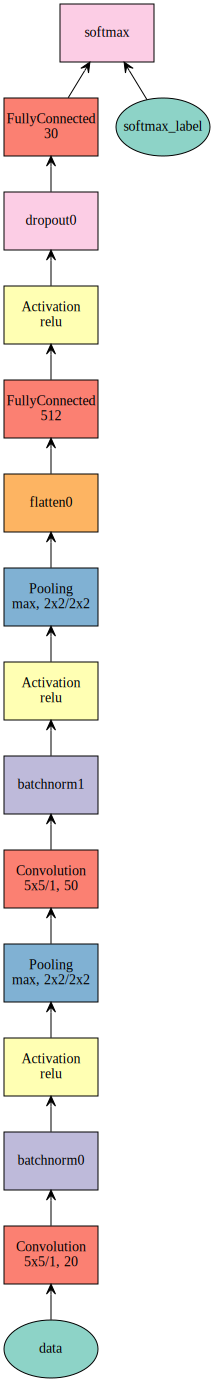

In [16]:
data = mx.sym.var('data')

conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20, name='conv1')
bn1 = mx.sym.BatchNorm(conv1, fix_gamma=True)
tanh1 = mx.sym.Activation(data=bn1, act_type='relu')
pool1 = mx.sym.Pooling(data=tanh1, pool_type='max', kernel=(2,2), stride=(2,2))

conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50, name='conv2')
bn2 = mx.sym.BatchNorm(conv2, fix_gamma=True)
tanh2 = mx.sym.Activation(data=bn2, act_type='relu')
pool2 = mx.sym.Pooling(data=tanh2, pool_type='max', kernel=(2,2), stride=(2,2))

flat = mx.sym.flatten(data=pool2)
fc1 = mx.sym.FullyConnected(data=flat, num_hidden=512)
tanh3 = mx.sym.Activation(data=fc1, act_type='relu')

drop = mx.symbol.Dropout(tanh3, p=0.5)
fc2 = mx.sym.FullyConnected(data=drop, num_hidden=num_class)

convnet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

mx.viz.plot_network(convnet)

In [17]:
model = mx.mod.Module(symbol=convnet, context=mx.gpu())

In [18]:
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params(initializer=mx.init.Uniform(scale=.01))
model.init_optimizer(optimizer='sgd', optimizer_params={'learning_rate':0.001, 'wd': 0.001})

metric = mx.metric.Accuracy()

In [19]:
chk_prefix='models/chkpt'
for epoch in range(400):
    train_iter.reset()
    metric.reset()
    
    st = time.time()
    for batch in train_iter:
        model.forward(data_batch=batch, is_train=True)
        model.update_metric(metric, batch.label)
        model.backward()
        model.update()
    
    if epoch % 30 == 0:
#         model_path = '{}_{}'.format(chk_prefix, epoch)
        model.save_checkpoint(chk_prefix, epoch)
        
    et = time.time()-st
    print('Epoch %d, Training %s, Time %.2f' % (epoch, metric.get(), et))

INFO:root:Saved checkpoint to "models/chkpt-0000.params"


Epoch 0, Training ('accuracy', 0.05029296875), Time 7.53
Epoch 1, Training ('accuracy', 0.14501953125), Time 5.63
Epoch 2, Training ('accuracy', 0.2470703125), Time 5.88
Epoch 3, Training ('accuracy', 0.34814453125), Time 5.87
Epoch 4, Training ('accuracy', 0.45654296875), Time 5.87
Epoch 5, Training ('accuracy', 0.5146484375), Time 5.87
Epoch 6, Training ('accuracy', 0.5703125), Time 5.85
Epoch 7, Training ('accuracy', 0.63134765625), Time 5.83
Epoch 8, Training ('accuracy', 0.67578125), Time 5.83
Epoch 9, Training ('accuracy', 0.7333984375), Time 5.83
Epoch 10, Training ('accuracy', 0.72119140625), Time 5.82
Epoch 11, Training ('accuracy', 0.76220703125), Time 5.82
Epoch 12, Training ('accuracy', 0.779296875), Time 5.82
Epoch 13, Training ('accuracy', 0.8017578125), Time 5.82
Epoch 14, Training ('accuracy', 0.81396484375), Time 5.82
Epoch 15, Training ('accuracy', 0.82275390625), Time 5.82
Epoch 16, Training ('accuracy', 0.84033203125), Time 5.82
Epoch 17, Training ('accuracy', 0.855

INFO:root:Saved checkpoint to "models/chkpt-0030.params"


Epoch 30, Training ('accuracy', 0.9287109375), Time 7.72
Epoch 31, Training ('accuracy', 0.9375), Time 5.59
Epoch 32, Training ('accuracy', 0.939453125), Time 5.82
Epoch 33, Training ('accuracy', 0.94189453125), Time 5.81
Epoch 34, Training ('accuracy', 0.94384765625), Time 5.82
Epoch 35, Training ('accuracy', 0.9453125), Time 5.82
Epoch 36, Training ('accuracy', 0.96044921875), Time 5.82
Epoch 37, Training ('accuracy', 0.953125), Time 5.82
Epoch 38, Training ('accuracy', 0.95263671875), Time 5.82
Epoch 39, Training ('accuracy', 0.9521484375), Time 5.82
Epoch 40, Training ('accuracy', 0.955078125), Time 5.82
Epoch 41, Training ('accuracy', 0.953125), Time 5.83
Epoch 42, Training ('accuracy', 0.9560546875), Time 5.83
Epoch 43, Training ('accuracy', 0.9638671875), Time 5.84
Epoch 44, Training ('accuracy', 0.95751953125), Time 5.86


KeyboardInterrupt: 

In [45]:
model.score(eval_iter, metric)

[('accuracy', 0.984375)]

In [ ]:
# ls data1

In [ ]:
# # I took a picture of my hand 
# pred_im = cv2.imread('data1/test-crop.png', 0)
# plt.imshow(pred_im)

In [ ]:
# pred_im.shape

In [ ]:
# pred_res = cv2.resize(pred_im,(200, 200), interpolation = cv2.INTER_CUBIC)
# plt.imshow(pred_res)

In [ ]:
# test_ = np.empty((1,1,200,200))
# test_[0][0] = pred_res
# lb = np.array([0])

In [ ]:
# test_.shape#, lb.shape

In [ ]:
# eval_iter = mx.io.NDArrayIter(test_, lb, batch_size=1)

In [ ]:
# d = Batch([mx.nd.array(pred_res)])
# # d, pred_res.shape
# model.forward(data_batch=d)

In [ ]:
# def get_image(url, show=False):
#     # download and show the image
# #     fname = mx.test_utils.download(url)
# #     img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
#     img = cv2.imread(url, 0)
#     if img is None:
#          return None
#     if show:
#          plt.imshow(img)
#          plt.axis('off')

#     img = cv2.resize(img, (200, 200), interpolation = cv2.INTER_CUBIC)
# #     img = np.swapaxes(img, 0, 2)
# #     img = np.swapaxes(img, 1, 2)
#     img = img[np.newaxis, np.newaxis, :]
#     return img

In [ ]:
# from collections import namedtuple
# Batch = namedtuple('Batch', ['data'])
# def predict(url):
#     img = get_image(url, show=True)
#     print img.shape
#     print Batch([mx.nd.array(img)])
#     # compute the predict probabilities
# #     model.forward(Batch([mx.nd.array(img)]), is_train=False)
# #     prob = mod.get_outputs()[0].asnumpy()
# #     # print the top-5
# #     prob = np.squeeze(prob)
# #     a = np.argsort(prob)[::-1]
# #     for i in a[0:5]:
# #         print('probability=%f, class=%s' %(prob[i], labels[i]))

In [ ]:
# # test picture with label 0
# # pred = model.predict(eval_iter)#.asnumpy()
# predict('data1/test-crop.png')

In [ ]:
# pred.argmax() # correct!

In [48]:
sym, arg_params, aux_params = mx.model.load_checkpoint('models/chkpt', 210)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,200,200))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

In [55]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

mod.forward(Batch([mx.nd.array(res)]))

In [57]:
mod.get_outputs()[0]


[[  1.07715632e-08   8.27669567e-07   8.37977893e-07   3.39835642e-05
    7.99212648e-06   6.54119503e-07   9.99485110e-07   5.14404292e-06
    4.32374654e-05   2.37050335e-09   3.48504291e-05   3.76414590e-07
    1.09531293e-05   6.28522757e-05   7.16310478e-06   1.60254403e-05
    1.17708172e-04   1.41441080e-04   1.19263780e-06   7.00090372e-04
    1.82696458e-05   1.46264331e-02   2.30391279e-08   9.25918903e-06
    2.49642995e-04   3.70244466e-04   5.02268435e-04   9.87173116e-05
    3.34505085e-03   9.79593754e-01]]
<NDArray 1x30 @cpu(0)>

In [ ]:
#    # save a model to mymodel-symbol.json and mymodel-0100.params
#     prefix = 'mymodel'
#     iteration = 100
#     model.save(prefix, iteration)

#     # load model back
#     model_loaded = mx.model.FeedForward.load(prefix, iteration)